In [179]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [180]:
import numpy as np
import h5py
#from chainconsumer import ChainConsumer
from corner import corner

In [181]:
! ls -ltr /scratch/users/swmclau2/PearceMCMC/*.hdf5

-rw-r--r-- 1 swmclau2 risahw      12928 Jun  2  2019 /scratch/users/swmclau2/PearceMCMC/HSAB_HOD_xi_gg_.hdf5
-rw-r--r-- 1 swmclau2 risahw  285400697 Jun  2  2019 /scratch/users/swmclau2/PearceMCMC/HOD_xi_gg_rmin_10.0_CorrAB.hdf5
-rw-r--r-- 1 swmclau2 risahw  328324673 Jun  2  2019 /scratch/users/swmclau2/PearceMCMC/VpeakSHAM_xi_gg_rmin_10.0_HSAB.hdf5
-rw-r--r-- 1 swmclau2 risahw  325737318 Jun  2  2019 /scratch/users/swmclau2/PearceMCMC/HOD_xi_gg_rmin_10.0_HSAB.hdf5
-rw-r--r-- 1 swmclau2 risahw  305678919 Jun  2  2019 /scratch/users/swmclau2/PearceMCMC/VpeakSHAM_xi_gg_rmin_10.0_CorrAB.hdf5
-rw-r--r-- 1 swmclau2 risahw  342139483 Jun  2  2019 /scratch/users/swmclau2/PearceMCMC/MpeakSHAM_xi_gg_rmin_10.0_HSAB.hdf5
-rw-r--r-- 1 swmclau2 risahw  292621035 Jun  2  2019 /scratch/users/swmclau2/PearceMCMC/HSAB_HOD_xi_gg_rmin_10.0_CorrAB.hdf5
-rw-r--r-- 1 swmclau2 risahw  364872434 Jun  2  2019 /scratch/users/swmclau2/PearceMCMC/MpeakSHAM_xi_gg_rmin_10.0_CorrAB.hdf5
-rw-r--r-- 1 swmclau2 risahw

In [182]:
#fname = '/scratch/users/swmclau2/PearceMCMC/500_walkers_10000_steps_chain_cosmo_zheng_xi_lowmsat.npy'
fname = '/scratch/users/swmclau2/PearceMCMC/HOD_wp_ds_rmin_None_HOD.hdf5'

In [183]:
f = h5py.File(fname, 'r')

In [184]:
f.attrs.keys()

[u'emu_type',
 u'training_file',
 u'emu_cov_fname',
 u'fixed_params',
 u'emu_hps',
 u'true_data_fname',
 u'true_cov_fname',
 u'sim',
 u'obs',
 u'cov',
 u'nsteps',
 u'param_names',
 u'mcmc_type',
 u'nwalkers',
 u'nlive',
 u'dlogz',
 u'nburn',
 u'seed',
 u'chain_fixed_params']

In [185]:
from ast import literal_eval

In [186]:
f.keys()

[u'chain', u'cov', u'data', u'lnprob']

In [187]:
n_walkers = f.attrs['nwalkers']

In [188]:
print n_walkers

200


In [189]:
f.keys()

[u'chain', u'cov', u'data', u'lnprob']

In [190]:
f.attrs['sim']

'sherlock'

In [191]:
sim_info = f.attrs['sim']

In [192]:
n_burn = 10000
chain = f['chain'][n_burn*n_walkers:]

In [193]:
chain = chain[np.all(chain!=0.0, axis = 1), :]

In [194]:
print chain.shape, chain.shape[0]/n_walkers

(8000000, 12) 40000


In [195]:
gal_type = f.attrs['sim']

In [196]:
chain_pnames = f.attrs['param_names']

In [197]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'ln10As', 'H0', 'Neff', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [198]:
param_name_dict = {'ombh2': r'$\Omega_b h^2$', 'omch2': r'$\Omega_c h^2$','w0': r'$w_0$','ns': r'$n_s$', \
                   'ln10As': r'$\ln(10A_s)$', 'H0': r'$H_0$','Neff': r'$N_{eff}$',\
               'mean_occupation_centrals_assembias_corr1': r'$\rho_{cen}$',\
                 'mean_occupation_satellites_assembias_corr1':r'$\rho_{sat}$',\
                   'mean_occupation_centrals_assembias_param1': r'$\mathcal{A}_{cen}$',\
                 'mean_occupation_satellites_assembias_param1':r'$\mathcal{A}_{sat}$',\
                   'mean_occupation_centrals_assembias_slope1': r'$\mathcal{B}_{cen}$',\
                 'mean_occupation_satellites_assembias_slope1':r'$\mathcal{B}_{sat}$',\
                   'logM1': r'$\log(M_1)$','logM0': r'$\log(M_0)$','sigma_logM': r'$\sigma_{\log M }$',
                   'conc_gal_bias': r'$\eta$', 'alpha':r'$\alpha$' }

In [199]:
hod_param_names = []
cosmo_param_names = []
cosmo_names = set(['ombh2', 'omch2', 'w0', 'ns', 'ln10As', 'H0', 'Neff'])
for pname in chain_pnames:
    if pname in cosmo_names:
        cosmo_param_names.append(param_name_dict[pname])
    else:
        hod_param_names.append(param_name_dict[pname])

In [200]:
f.close()

In [201]:
cosmo_param_names

['$\\Omega_b h^2$',
 '$\\Omega_c h^2$',
 '$w_0$',
 '$n_s$',
 '$\\ln(10A_s)$',
 '$H_0$',
 '$N_{eff}$']

In [202]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [203]:
MAP = chain.mean(axis = 0)
print MAP

[ 2.1172708e-02  1.2238616e-01 -1.0118175e+00  9.9293679e-01
  3.3210056e+00  6.4205299e+01  3.4680295e+00  1.5423774e+01
  1.3778981e+01  2.5621307e-01  1.0474526e+00  7.0813411e-01]


In [204]:
hod_idxs = np.array(range(len(cosmo_param_names), len(cosmo_param_names)+len(hod_param_names)))
cosmo_idxs = np.array(range(len(cosmo_param_names)))

In [205]:
if chain.shape[1] == 7:
    cosmo_chain = chain
elif chain.shape[1] > 10:
    hod_chain = chain[:,hod_idxs]
    cosmo_chain = chain[:,cosmo_idxs]
else:
    hod_chain = chain

In [206]:
if gal_type == 'HOD':
    from pearce.mocks import cat_dict
    cosmo_params = {'simname': sim_info['simname'], 'boxno': sim_info['sim_hps']['boxno'],\
                    'realization': sim_info['sim_hps']['realization'], 'scale_factors':[sim_info['scale_factor']],\
                    'system': sim_info['sim_hps']['system']}
    cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!
    
    cpv = cat._get_cosmo_param_names_vals()

    cat_val_dict =  {key: val for key, val in zip(cpv[0], cpv[1])}
    cosmo_true_vals = [cat_val_dict[pn] for pn in chain_pnames if pn in cat_val_dict]
    
    hod_params = sim_info['hod_params']
    hod_true_vals = [hod_params[key] for key in chain_pnames if key in hod_params]
    hod_true_vals.insert(0, 0)
    hod_true_vals.insert(3, 0)
    hod_true_vals.append(1.0)
    #hod_true_vals = [MAP[idx] for idx, key in enumerate(chain_pnames) if key in hod_params]
else: #SHAM
    #cosmo_true_vals = [3.7,70.7317,-1.13151,0.12283, 3.11395,  0.953515,  0.021762]
    #cosmo_true_vals = [0.046*0.7**2, (0.27-0.046)*0.7**2, -1, 0.95, 3.08511, 70, 3.04] 
    # multidark
    cosmo_true_vals = np.array([0.02214, 0.1175, -1, 0.9676, 3.0819, 0.6881*100, 3.04]) #darksky
    hod_true_vals = np.array([np.inf for p in hod_param_names])

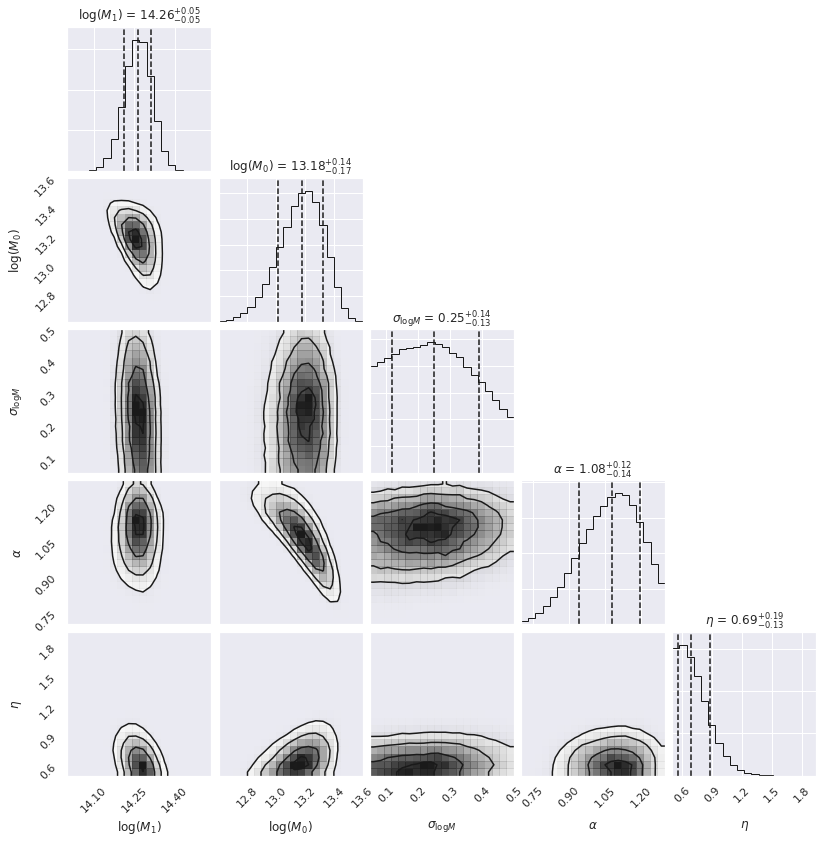

In [207]:
corner(hod_chain, labels=hod_param_names,
                       quantiles=[0.16, 0.5, 0.84],
                        truths = hod_true_vals,
                       #range = [emu.get_param_bounds(n) for n in hod_params],
                       show_titles=True, title_kwargs={"fontsize": 12},
                      plot_datapoints =False, plot_density = True);

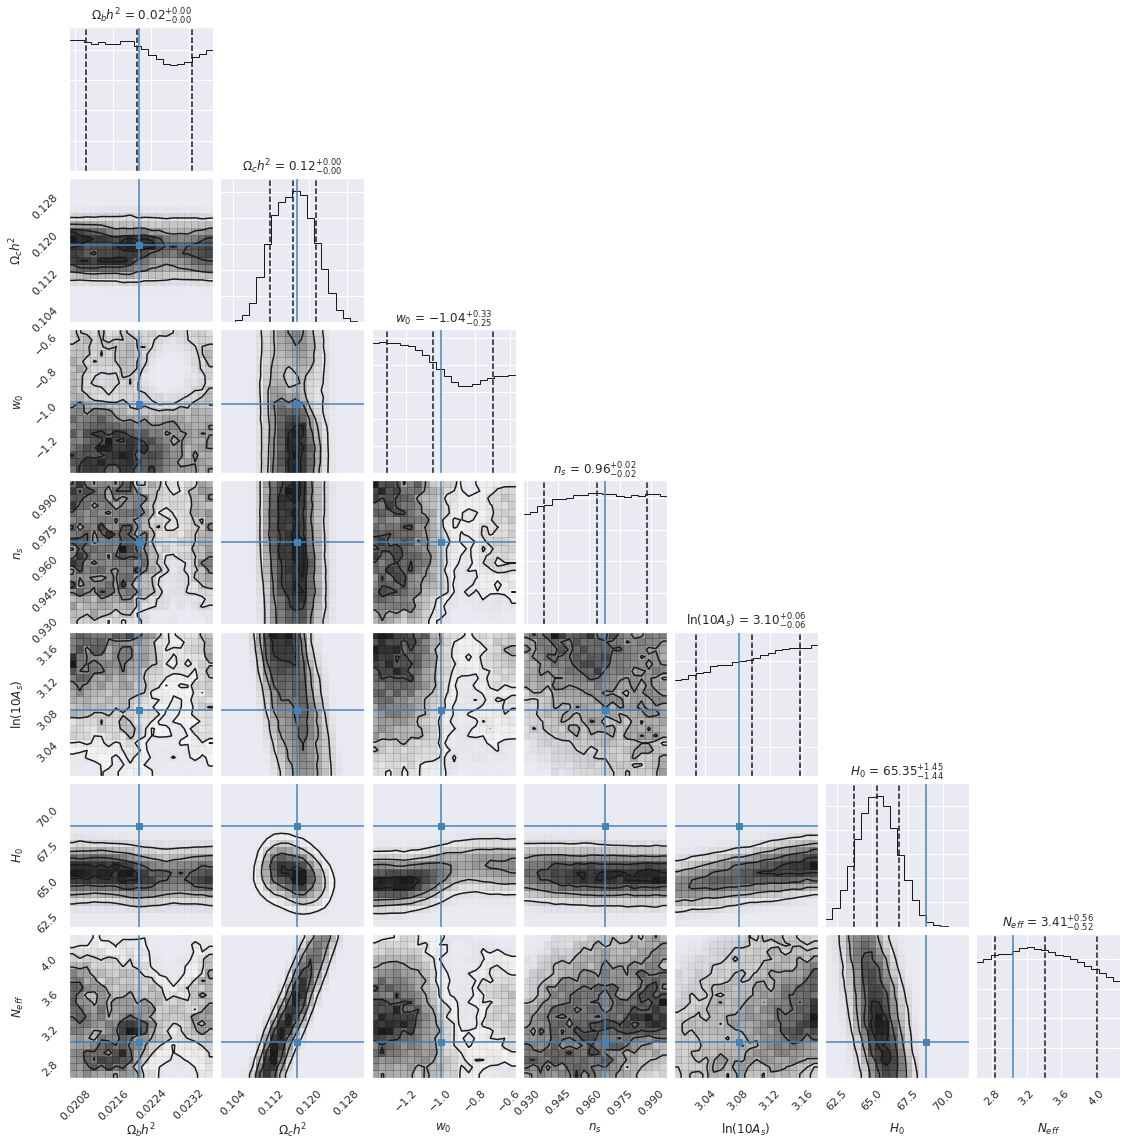

In [208]:
corner(cosmo_chain, labels=cosmo_param_names,
                       quantiles=[0.13, 0.5, 0.86],
                        truths = cosmo_true_vals,
                       show_titles=True, title_kwargs={"fontsize": 12},
                          plot_datapoints = False, plot_density = True);

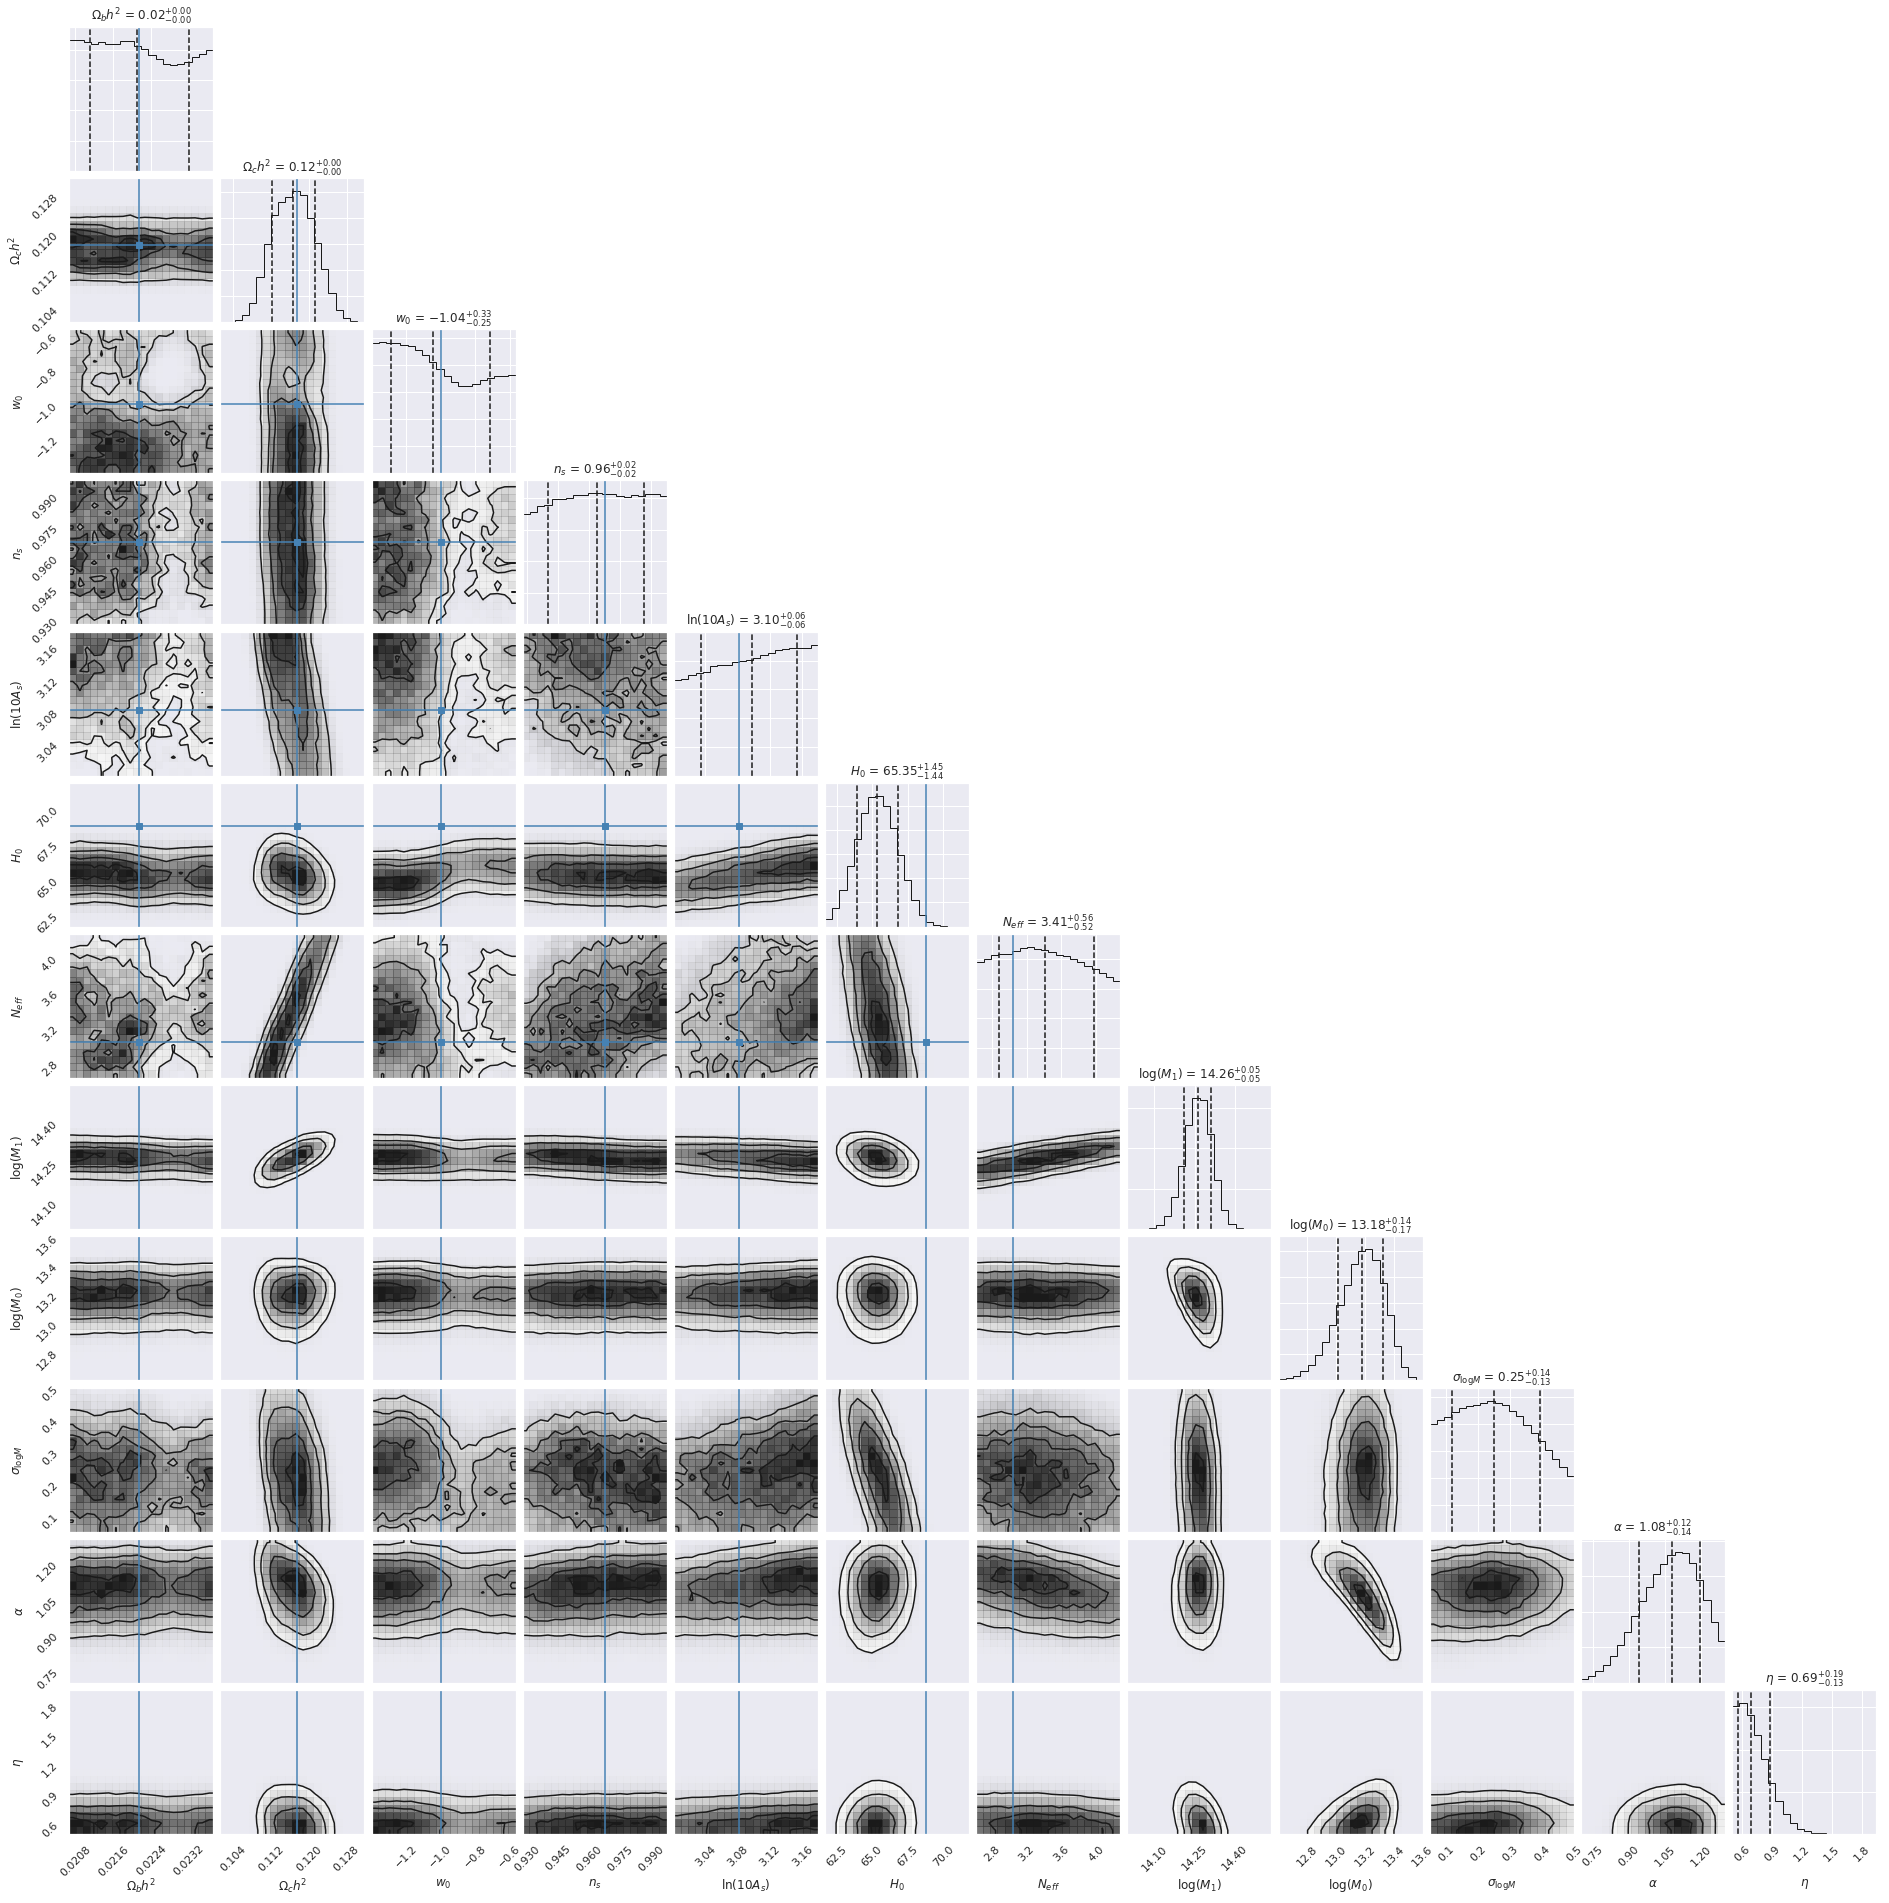

In [209]:
l = cosmo_param_names
l.extend(hod_param_names)
corner(chain, 
       labels = l,
       truths = np.hstack([cosmo_true_vals, hod_true_vals]),
    quantiles=[0.16, 0.5, 0.84], show_titles=True,title_kwargs={"fontsize": 12},
    plot_datapoints = False, plot_density = True);

In [210]:
f.close()